<a href="https://colab.research.google.com/github/yiyoungkim/yy/blob/main/CV_AL1_test7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive



The goal is to solve the fine-grained image classification train the model using hyperparameter tuning, data augmentation, etc., and write a report with a detailed analysis of the results.
 - Is the problem solved in an appropriate way?
- Are different hyperparameters and data augmentation used for training and are the results compared and analyzed?
- Is the use of appropriate visualization tools and experiment tools for your reports?
e.g., GradCAM, Weight & Biases, etc.

In [3]:
!pip install adabelief-pytorch

In [4]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor,Normalize, RandomHorizontalFlip, Resize
from torch.utils.data import ConcatDataset
from torchvision.transforms import RandAugment

import torchvision.models as models
from torch.utils.data import Dataset, DataLoader

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image,ImageFilter,ImageEnhance

from adabelief_pytorch import AdaBelief
from torch.optim.lr_scheduler import CosineAnnealingLR

from collections import Counter
from torch.utils.data import WeightedRandomSampler


# 랜덤 시드 설정
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)

### GPU Setting ###
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print(DEVICE)




cuda


In [5]:
# !pip install wandb
# import wandb
# wandb.login()

# # Initialize wandb
# wandb.init(project="gpt5")
# config = wandb.config
# config.dropout = 0.01

In [6]:

### Custom Dataset ###
class CUB2011(Dataset):
  def __init__(self, transform, mode='train'):
    self.transform = transform
    self.mode = mode

    if self.mode == 'train':
      self.image_folder = os.listdir('/content/drive/MyDrive/datasets/train')
    elif self.mode == 'valid':
      self.image_folder = os.listdir('/content/drive/MyDrive/datasets/valid')
    elif self.mode == 'test':
      self.image_folder = os.listdir('/content/drive/MyDrive/datasets/test')

  def __len__(self):
    return len(self.image_folder)

  def __getitem__(self, idx):
    img_path = self.image_folder[idx]
    img = Image.open(os.path.join('/content/drive/MyDrive/datasets', self.mode, img_path)).convert('RGB')
    img = self.transform(img)

    label = img_path.split('_')[-1].split('.')[0]
    label = int(label)
    return (img, label)


In [7]:
# Geomentric transform + Visual corruptions
class AddGaussianNoise(object):
    def __init__(self, mean=0, std=1, p=0.5):
        self.mean = mean
        self.std = std
        self.p = p

    def __call__(self, img):
        if np.random.rand() < self.p:
            img_array = np.array(img)
            noise = np.random.normal(self.mean, self.std, img_array.shape)
            noisy_image = np.clip(img_array + noise, 0, 255)  # Clip values to the range [0, 255]
            return Image.fromarray(noisy_image.astype(np.uint8))
        else:
            return img

    def __repr__(self):
        return self.__class__.__name__ + f'(mean={self.mean}, std={self.std}, p={self.p})'


class AdjustContrast(object):
    def __init__(self, factor=1.0):
        self.factor = factor

    def __call__(self, img):
        enhancer = ImageEnhance.Contrast(img)
        img = enhancer.enhance(self.factor)
        return img

    def __repr__(self):
        return self.__class__.__name__ + f'(factor={self.factor})'

class AdjustBrightness(object):
    def __init__(self, factor=1.0):
        self.factor = factor

    def __call__(self, img):
        enhancer = ImageEnhance.Brightness(img)
        img = enhancer.enhance(self.factor)
        return img

    def __repr__(self):
        return self.__class__.__name__ + f'(factor={self.factor})'


# Mix up
def mixup_data(x, y, alpha=1.0):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size, device=x.device, dtype=torch.long)  # GPU에 있는 x.device를 사용하여 인덱스를 GPU로 전송

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [8]:
### Data Preprocessing ###
transforms_train_origin = transforms.Compose([transforms.Resize((448,448), Image.BICUBIC),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                       ])
transforms_test = transforms.Compose([transforms.Resize((448,448), Image.BICUBIC),
                                       transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                       ])

# Apply RandAugment
transforms_train_rand = transforms.Compose([
    transforms.Resize((448, 448), Image.BICUBIC),
    RandAugment(5,3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Geomentric transform + Visual corruptions
transforms_train_g_v = transforms.Compose([
    transforms.Resize((448, 448), Image.BICUBIC),
    transforms.RandomResizedCrop(448),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomRotation(30),
    AddGaussianNoise(mean=0, std=25, p=0.5),  # 가우시안 노이즈를 추가합니다.
    AdjustContrast(factor=2.0),  # 대비를 조절합니다.
    AdjustBrightness(factor=1.5),  # 밝기를 조절합니다.
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


BATCH_SIZE = 64

train_set_origin = CUB2011(mode='train',
                    transform=transforms_train_origin)
val_set = CUB2011(mode='valid',
                  transform=transforms_test)
test_set = CUB2011(mode='test',
                  transform=transforms_test)

# 데이터 증강을 위해 원래 데이터를 복사하고 추가
train_set_augmented = CUB2011(mode='train', transform=transforms_train_rand)
train_set_augmented2 = CUB2011(mode='train',transform=transforms_train_g_v)

train_loader = DataLoader(train_set_origin,batch_size=BATCH_SIZE,shuffle=True)

# Mixup된 이미지를 train_loader에 추가
train_set_mixup = []
for input, target in train_loader:
    mixed_input, target_a, target_b, lam = mixup_data(input, target, alpha=1.0)
    train_set_mixup.append((mixed_input, target_a, target_b, lam))
train_set_mixup = transforms.Compose([transforms.Resize((448,448), Image.BICUBIC),
                                       transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                       ])
train_set_mixup = CUB2011(mode='train', transform=train_set_mixup)

# 각 클래스의 샘플 수를 계산
class_counts = Counter([label for _, label in train_set_origin])

# 가장 작은 클래스의 샘플 수를 찾아 minority_class_label로 지정
minority_class_label = min(class_counts, key=class_counts.get)

# Create a new dataset from replicated_data
replicated_data = CUB2011(mode='train', transform=transforms_train_origin) #rand--> origin
replicated_data.image_folder = [data for data in train_set_origin.image_folder if data[1] == minority_class_label]



# 두 데이터셋을 연결하여 새로운 훈련 데이터셋 생성
# train_set_combined = ConcatDataset([train_set_origin, replicated_data,
#                                     train_set_augmented,train_set_augmented2,train_set_mixup])
train_set_combined = ConcatDataset([train_set_origin,train_set_mixup])

print('Num of each dataset: ',len(train_set_combined),len(val_set),len(test_set))


#-----------------------------------------------------------------------
# Dataloader class는 bath기반의 딥러닝모델 학습을 위해서 mini batch를 만들어주는 역할을 한다
# dataloader를 통해 dataset의 전체 데이터가 batch size로 나뉘게 된다
# train_loader = DataLoader(train_set_combined,batch_size=BATCH_SIZE,shuffle=True)
train_loader = DataLoader(train_set_combined, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set,batch_size=BATCH_SIZE,shuffle=False)
test_loader = DataLoader(test_set,batch_size=BATCH_SIZE,shuffle=False)

print("Loaded dataloader")



Num of each dataset:  4720 296 298
Loaded dataloader


In [9]:
!pip install --upgrade adabelief-pytorch

In [10]:
### Model / Optimizer ###
EPOCH = 30

lr = 0.001

model = models.resnet18(pretrained=True)

### Tranfer Learning ###
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features,512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 50)  # 클래스 수에 맞게 조정
)
model.to(DEVICE)

#Weight Decay 적용: L2 regularization을 통해 과적합을 방지
# optimizer = AdaBelief(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-16, weight_decouple=True, rectify=True)
optimizer = AdaBelief(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-16, weight_decouple=True, rectify=True, weight_decay=1e-5)


# 코사인 앤니얼링 스케줄러 초기화
dataset_size = len(train_set_combined)  # 훈련 데이터셋 크기

T_max = dataset_size / BATCH_SIZE  # 한 주기의 에폭 수
scheduler = CosineAnnealingLR(optimizer, T_max=T_max, eta_min=0.001)

print("Created a learning model and optimizer")



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 63.1MB/s]


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief
Created a learning model and optimizer


In [11]:
### Train/Evaluation ###
def train(model,train_loader,optimizer,epoch):
  model.train()
  for i,(image,target) in enumerate(train_loader):
    image,target = image.to(DEVICE),target.to(DEVICE)
    output = model(image)
    optimizer.zero_grad()
    # loss func을 어떤 것을 사용할 것인지?
    train_loss = F.cross_entropy(output,target).to(DEVICE)

    train_loss.backward()
    optimizer.step()

    # Implement gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.25)  # You can adjust the 'max_norm' parameter as needed

    # 스케줄러 업데이트
    scheduler.step()

    if i%10 ==0:
      print(
          f'Train Epoch: {epoch} [{i}/{len(train_loader)}]\tloss: {train_loss.item():6f}')

  return train_loss

def evaluate(model,val_loader):
  model.eval()
  eval_loss = 0
  correct = 0
  with torch.no_grad():
    for i,(image,target) in enumerate(val_loader):
      image,target = image.to(DEVICE),target.to(DEVICE)
      output = model(image)

      eval_loss += F.cross_entropy(output,target, reduction='sum').item()
      pred = output.max(1,keepdim=True)[1]
      correct += pred.eq(target.view_as(pred)).sum().item()

  eval_loss /= len(val_loader.dataset)
  eval_accuracy = 100*correct / len(val_loader.dataset)
  return eval_loss,eval_accuracy

In [12]:

#### Mian ###
start = time.time()
best = 0

train_losses = []  # 훈련 손실을 저장할 목록
val_losses = []    # 검증 손실을 저장할 목록
val_accuracys = []

# 디렉토리 생성
os.makedirs('./best_model', exist_ok=True)

for epoch in range(EPOCH):
  train_loss = train(model,train_loader,optimizer,epoch)
  val_loss,val_accuracy = evaluate(model,val_loader)

  # # Log metrics to wandb
  # wandb.log({"loss": loss.item()})

  # 훈련 및 검증 손실을 목록에 추가
  train_losses.append(train_loss)
  val_losses.append(val_loss)

  # Save best model
  if val_accuracy > best:
    best = val_accuracy
    torch.save(model.state_dict(),"./best_model.pth")

  val_accuracys.append(val_accuracy)
  print(f"[{epoch}]Validation Loss: {val_loss:.4f},Accuracy: {val_accuracy:.4f}%")

# Test result
test_loss,test_accuracy = evaluate(model,test_loader)
print(f'[FINAL] Test Loss: {test_loss:.4f},Accuracy: {test_accuracy:.4f}%')

end = time.time()
elasped_time = end - start

print("Best Accuracy: ",best)
print(
    f"Elasped Time: {int(elasped_time/3600)}h, {int(elasped_time/60)}m, {int(elasped_time%60)}s")
print(
    f"time: {int(elasped_time/3600)}h, {int(elasped_time/60)}m, {int(elasped_time%60)}s")

Train Epoch: 0 [0/74]	loss: 4.003352
Train Epoch: 0 [10/74]	loss: 3.983781
Train Epoch: 0 [20/74]	loss: 3.899387
Train Epoch: 0 [30/74]	loss: 3.879162
Train Epoch: 0 [40/74]	loss: 3.780858
Train Epoch: 0 [50/74]	loss: 3.621824
Train Epoch: 0 [60/74]	loss: 3.283753
Train Epoch: 0 [70/74]	loss: 3.159452
[0]Validation Loss: 2.7141,Accuracy: 37.8378%
Train Epoch: 1 [0/74]	loss: 2.920783
Train Epoch: 1 [10/74]	loss: 2.451777
Train Epoch: 1 [20/74]	loss: 2.039222
Train Epoch: 1 [30/74]	loss: 2.058597
Train Epoch: 1 [40/74]	loss: 1.789847
Train Epoch: 1 [50/74]	loss: 1.435601
Train Epoch: 1 [60/74]	loss: 1.291141
Train Epoch: 1 [70/74]	loss: 1.300678
[1]Validation Loss: 1.4644,Accuracy: 77.7027%
Train Epoch: 2 [0/74]	loss: 1.166210
Train Epoch: 2 [10/74]	loss: 1.131066
Train Epoch: 2 [20/74]	loss: 1.090870
Train Epoch: 2 [30/74]	loss: 1.128596
Train Epoch: 2 [40/74]	loss: 0.856537
Train Epoch: 2 [50/74]	loss: 0.753056
Train Epoch: 2 [60/74]	loss: 0.643740
Train Epoch: 2 [70/74]	loss: 0.495703

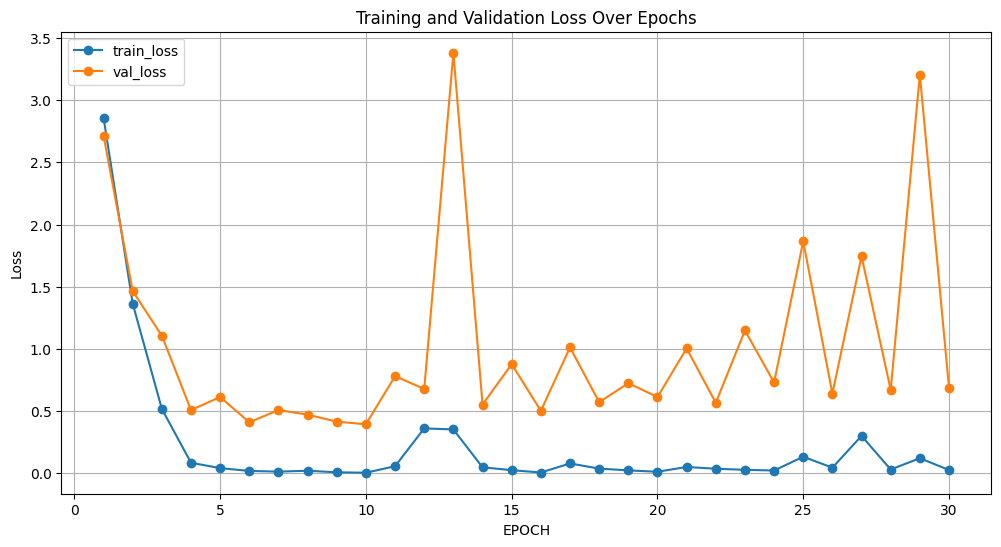

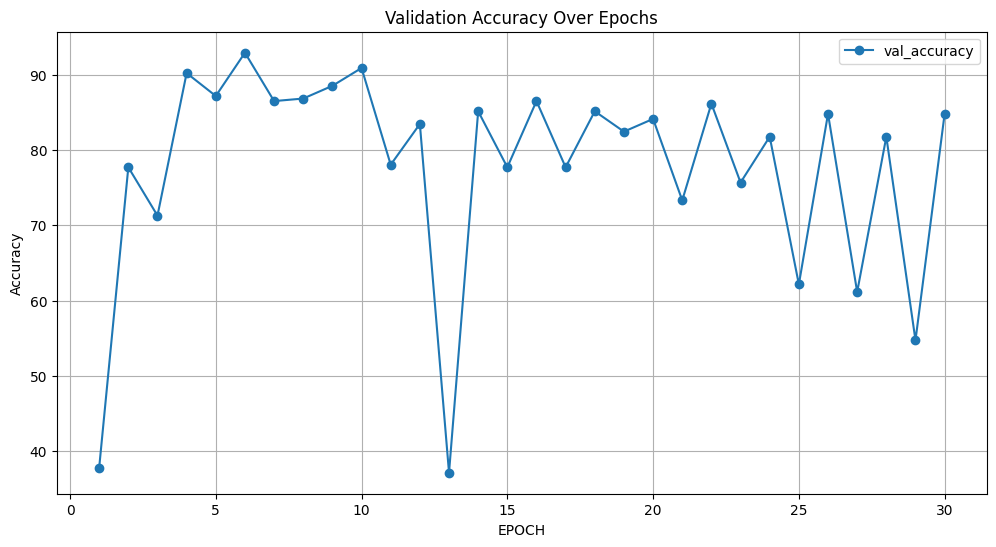

In [13]:
# 이제 손실 값을 플로팅합니다.
import matplotlib.pyplot as plt

# train_loss와 val_loss 텐서를 CPU로 이동하고 NumPy 배열로 변환
train_losses = [loss.cpu().detach().numpy() if isinstance(loss, torch.Tensor) else loss for loss in train_losses]
val_losses = [loss.
              cpu().detach().numpy() if isinstance(loss, torch.Tensor) else loss for loss in val_losses]

plt.figure(figsize=(12, 6))
plt.plot(range(1, EPOCH + 1), train_losses, label='train_loss', marker='o')
plt.plot(range(1, EPOCH + 1), val_losses, label='val_loss', marker='o')
plt.title('Training and Validation Loss Over Epochs')

plt.xlabel('EPOCH')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


val_accuracys = [acc.cpu().detach().numpy() if isinstance(acc, torch.Tensor) else acc for acc in val_accuracys]
plt.figure(figsize=(12, 6))
plt.plot(range(1, EPOCH + 1), val_accuracys, label='val_accuracy', marker='o')
plt.title('Validation Accuracy Over Epochs')

plt.xlabel('EPOCH')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# !pip install git+https://github.com/jacobgil/pytorch-grad-cam.git

# import copy
# from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
# from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
# from pytorch_grad_cam.utils.image import show_cam_on_image

# import numpy as np
# from PIL import Image

# import torchvision
# #
# # Pick up layers for visualization
# target_layers = [model.layer4[-1]]
# grad_cam = GradCam(model = model, target_layers, use_cuda=False)

# # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
# grayscale_cam = cam(input_tensor=input_tensor)

# # In this example grayscale_cam has only one image in the batch:
# grayscale_cam = grayscale_cam[0, :]
# visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

In [15]:
# # gradCAM
# import cv2
# from google.colab.patches import cv2_imshow                                      # cv2.imshow() should be replaced to cv2_imshow() in google.colab
# import glob
# import numpy as np


# class GradCam(nn.Module):
#     def __init__(self, model, module, layer):
#         super().__init__()
#         self.model = model
#         self.module = module
#         self.layer = layer
#         self.register_hooks()

#     def register_hooks(self):
#         for modue_name, module in self.model._modules.items():
#             if modue_name == self.module:
#                 for layer_name, module in module._modules.items():
#                     if layer_name == self.layer:
#                         module.register_forward_hook(self.forward_hook)
#                         module.register_backward_hook(self.backward_hook)

#     def forward(self, input, target_index):
#         outs = self.model(input)
#         outs = outs.squeeze()                                                    # [1, num_classes]  --> [num_classes]
#         outs = outs.to(DEVICE)

#         # 가장 큰 값을 가지는 것을 target index 로 사용
#         if target_index is None:
#             target_index = outs.argmax()
#             target_index = target_index.to(DEVICE)

#         outs[target_index].backward(retain_graph=True)
#         a_k = torch.mean(self.backward_result, dim=(1, 2), keepdim=True)         # [512, 1, 1]
#         out = torch.sum(a_k * self.forward_result, dim=0).cuda()                 # [512, 7, 7] * [512, 1, 1]
#         out = torch.relu(out) / torch.max(out)                                   # 음수를 없애고, 0 ~ 1 로 scaling # [7, 7]
#         out = F.upsample_bilinear(out.unsqueeze(0).unsqueeze(0), [224, 224])     # 4D로 바꿈
#         return out.cuda().detach().squeeze().numpy()

#     def forward_hook(self, _, input, output):
#         self.forward_result = torch.squeeze(output)

#     def backward_hook(self, _, grad_input, grad_output):
#         self.backward_result = torch.squeeze(grad_output[0])


# if __name__ == '__main__':

#     def preprocess_image(img):
#         means = [0.485, 0.456, 0.406]
#         stds = [0.229, 0.224, 0.225]

#         preprocessed_img = img.copy()[:, :, ::-1]
#         for i in range(3):
#             preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - means[i]
#             preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / stds[i]
#         preprocessed_img = np.ascontiguousarray(np.transpose(preprocessed_img, (2, 0, 1)))
#         preprocessed_img = torch.from_numpy(preprocessed_img)
#         preprocessed_img.unsqueeze_(0)
#         input = preprocessed_img.requires_grad_(True)
#         return input


#     def show_cam_on_image(img, mask):

#         # mask = (np.max(mask) - np.min(mask)) / (mask - np.min(mask))
#         heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
#         heatmap = np.float32(heatmap) / 255
#         cam = heatmap + np.float32(img)
#         cam = cam / np.max(cam)
#         cv2_imshow(np.uint8(255 * cam))                                          # cv2_imshow()에서 두 개의 parameter 사용 불가 --> print 부분과 imshow 부분으로 분리
#         print("cam")
#         cv2_imshow(np.uint8(heatmap * 255))
#         print("heat map\n\n\n")
#         cv2.waitKey()



#     print(model)
#     #model.eval()

#     grad_cam = GradCam(model=model, module='features', layer='30')
#     root = '/content/gdrive/MyDrive/CUB_200_2011_repackage_class50/datasets/test'
#     img_list = os.listdir(root)
#     img_list = sorted(glob.glob(os.path.join(root, '*.jpg')))
#     i = 0                                                                        # just for numbering heat maps
#     for img_path in img_list:
#         img = cv2.imread(img_path, 1)
#         #img = np.float32(cv2.resize(img, (224, 224))) / 255
#         img = np.float32(cv2.resize(img, (448, 448))) / 255
#         input = preprocess_image(img)
#         input = input.to(DEVICE)                                                 # input datas should be on GPU
#         mask = grad_cam(input, None)
#         print("<{}'th image>" .format(i))
#         show_cam_on_image(img, mask)
#         i = i + 1                                                                # update heat maps numbering

In [16]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"

# The local path to our target image
import random

# 테스트 데이터셋에서 무작위로 이미지 선택
random_index = random.randint(0, len(test_set) - 1)
img_path = test_set.image_folder[random_index]
img_path = os.path.join('/content/drive/MyDrive/datasets/test', image_path)
display(Image(img_path))

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

    #귀여워...

NameError: ignored

In [ ]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

In [ ]:
#keras안쓰고 토치기반으로 하는 중인데 잘 안되구 오류나서 고치는 중입니다

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

    def save_gradient(self, grad):
        self.gradients = grad

    def save_activation(self, module, input, output):
        self.activations = output

    def forward(self, x):
        return self.model(x)

    def backward(self, output, class_idx):
        self.model.zero_grad()
        one_hot_output = torch.FloatTensor(1, output.size()[-1]).zero_().to(DEVICE)
        one_hot_output[0][class_idx] = 1
        one_hot_output = one_hot_output.to(DEVICE)

        self.save_gradient(one_hot_output)
        output.backward(gradient=one_hot_output, retain_graph=True)

    def generate(self, input_image, class_idx):
        self.model.eval()
        hook = self.target_layer.register_forward_hook(self.save_activation)
        output = self.forward(input_image)
        hook.remove()

        self.backward(output, class_idx)

        gradients = self.gradients.cpu().data.numpy()[0]
        activations = self.activations.cpu().data.numpy()[0]

        weights = np.mean(gradients, axis=(1, 2))
        cam = np.dot(activations.T, weights)
        cam = np.maximum(0, cam)
        cam = cv2.resize(cam, input_image.shape[2:])
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam

# Now, modify your apply_gradcam function as follows:

def apply_gradcam(image_path, model, target_layer, classes):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image_tensor = transforms_valtest(image).unsqueeze(0).to(DEVICE)
    class_idx = model(image_tensor).max(1)[-1]

    gradcam = GradCAM(model=model, target_layer=target_layer)
    output = gradcam.generate(image_tensor, class_idx)

    heatmap = cv2.applyColorMap(np.uint8(255 * output), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam_img = heatmap + np.float32(image_tensor.cpu().squeeze().permute(1, 2, 0))
    cam_img = cam_img / np.max(cam_img)

    original_image = Image.open(image_path).convert('RGB')
    original_image = transforms_valtest(original_image).numpy().transpose(1, 2, 0)

    plt.imshow(cam_img)
    plt.title(f'Predicted Class: {classes[class_idx]}')
    plt.show()

import random

# 테스트 데이터셋에서 무작위로 이미지 선택
random_index = random.randint(0, len(test_set) - 1)
image_path = test_set.image_folder[random_index]
image_path = os.path.join('/content/drive/MyDrive/datasets/test', image_path)

# GradCAM 적용 함수 정의 (앞서 정의한 GradCAM 클래스와 apply_gradcam 함수)
class_idx = test_set.__getitem__(random_index)[1]  # 이미지의 실제 클래스 인덱스
target_layers = model.layer4[-1].to(DEVICE).conv2
apply_gradcam(image_path, model, target_layers, classes)  # classes 변수에는 클래스 이름 목록을 할당